In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
from aicsimageio import AICSImage as imio
from alive_progress import alive_bar
import cv2
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
sourcepath = "C:\\Temp\\Testdata\\AF\\2.5inch_LaserDiode\\20231023_2.5inch_50um_1um_2ms\\stack\\stack_MMStack_Default.ome.tif"

# Explanation
## Loaded raw images are processed as follows:
#### Temporary placeholder figure is set up
### Stack operations
#### Stack MIP for background subtraction
### Slice operations
#### Use selection of squaring or power dependent gaussian on 2D background-subtracted slice
#### Take either the maximum, mean or minimum intensity projection or the top n% of pixels along the projection direction
### Line operations
#### Apply S-G or median filter
#### Optionally do FFT, or just get a peak number of pixels for an intensity measurement
#### Obtain the roots to get FWHM or just use the intensity measurement
### Graph results
#### Allow for batch processing as well

In [3]:
#Load ops
datavol = np.asarray(np.squeeze(imio(sourcepath).data.copy()),dtype=np.int64)

<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304


# General functions

In [4]:
def rescale(np_arr_in,new_min,new_max):
    rescaled = ((new_max-new_min)*(np_arr_in-np.min(np_arr_in))/((np.max(np_arr_in)-np.min(np_arr_in))))+new_min
    return rescaled

# Stack functions

In [5]:
def proj_process(method,which_axis,stack):
    slices = range(np.shape(stack)[0])
    sequence=[]
    for slicenum in slices:
        sequence.append(project(method,which_axis,stack[slicenum,:,:]))
    return sequence

# Slice functions

In [6]:
def project(method, which_axis, data):
    proj = None
    dirn = 0
    match which_axis:
        case "X":
            dirn = 0
        case "Y":
            dirn = 1
        case _:
            dirn = 0
    match method:
        case "min":
            proj = np.min(data,axis=dirn)
        case "max":
            proj = np.max(data,axis=dirn)
        case "mean":
            proj = np.mean(data,axis=dirn)
        case "sum":
            proj = np.sum(data,axis=dirn)
        case "top 50":
            num_pixels = 50
            sorted = np.sort(data,kind='mergesort',axis=dirn)
            if(dirn>0):
                sorted = np.transpose(sorted)
            sorted = sorted[0-num_pixels:]
            print(np.shape(sorted))
            proj = np.mean(sorted,axis=0)
    return proj

# Line functions

In [7]:
def getroots_FWHM(vect):
    peak = max(vect)
    vall = min(vect)
    spline = sp.interpolate.UnivariateSpline(np.arange(0,int(len(vect)),1), vect-((peak+vall)/2), s=0)
    roots = spline.roots()
    #print(roots)
    return np.min(roots),np.max(roots)

In [8]:
def filter_line(line_in, **kwargs):
    # See explanation above for order of operations
    line_current = line_in
    if 'square' in kwargs:
        if kwargs.get('square')==True:
            line_current = line_current*line_current
        
    return line_current

# Graphing functions

In [9]:
def overlay_proj(fig,ax,imgpixels_ref,methods,colours,image,xplt,yplt,extra_line,extra_vals):
    scaling_frac = 0.4
    idx = 0;
    #plt.clf()
    for method in methods:
        imgpixels_ref.set_array(image)
        #imgpixels_ref.set_clim(0,5000)
        scaled_x_profile = rescale(project(method,"X",image),0,scaling_frac*n_x_px)
        scaled_y_profile = rescale(project(method,"Y",image),0,scaling_frac*n_y_px)
        xplt.set_ydata(scaled_x_profile)
        yplt.set_xdata(scaled_y_profile)
        idx = idx+1
    #Add extra line
    if(extra_vals is None):
        pass
    else:
        if(extra_vals.size == imgpixels_ref.get_array().shape[0]):
            #Along X
            extra_line.set_ydata(range(imgpixels_ref.get_array().shape[0]))
            extra_line.set_xdata((extra_vals/np.max(extra_vals))*(scaling_frac*imgpixels_ref.get_array().shape[1]))
            print(imgpixels_ref.get_array().shape[0])
        else:
            #Along Y
            extra_line.set_xdata(range(imgpixels_ref.get_array().shape[1]))
            extra_line.set_ydata((extra_vals/np.max(extra_vals))*(scaling_frac*imgpixels_ref.get_array().shape[0]))
    plt.draw()

# Analysis functions

In [10]:
def eval_img(method,which_axis,img_in,pct_brightest,force_stdev,savgol,FWHM_medfilt_scale):
    met_val = 0 # default
    met_scale=100
    linearised = np.ravel(img_in)
    n_biggest_elems = int(pct_brightest*linearised.size)
    proj_line = None
    #print(pct_brightest,n_biggest_elems)
    if(pct_brightest>=-1e-5 and proj_line == False):
        if(pct_brightest<1e-5):
            met_val = (met_scale*(np.max(img_in)/lin_vmax))
        else:
            big_indices = np.argpartition(linearised, -n_biggest_elems)[-n_biggest_elems:]
            bigvals = linearised[big_indices]
            met_val = met_scale*np.sum(bigvals)/(n_biggest_elems*lin_vmax)#bad to use predefined vmax - make it an input!
    else:
        proj_line = project(method,which_axis,img_in)
        if(savgol>0):
            proj_line = sp.ndimage.uniform_filter1d(proj_line,size=savgol, mode='nearest')
        if(FWHM_medfilt_scale>0):
            proj_line = np.roll(np.abs(np.fft.fft(proj_line)),int(len(proj_line)/2))
            proj_line = sp.signal.medfilt(proj_line,FWHM_medfilt_scale)
        #Do this before 2D trickery
        min,max = getroots_FWHM(proj_line)
        proj_line = np.asarray([proj_line])
        if(which_axis == "Y"):
            proj_line = np.transpose(proj_line)
        met_val = max-min
        if(force_stdev):
            met_val = np.std(proj_line)
    return met_val, proj_line

def proc_img(slicenum, gblur_x, asp_ratio, square_it, scale_it, bg_sub, targ_ax, proj_meth, int_pct,force_stdev,savgol, FFT_median):
    rawslice = datavol[slicenum,:,:]
    #Switch to using output_image
    output_image = rawslice 
    if(bg_sub):
        output_image = output_image-bg_img
    #Square if requested
    rangemax = lin_vmax
    if(square_it == True):
        output_image = np.square(output_image)
        rangemax = sq_vmax
    if(adaptive_smooth == True):
        gblur_x = int((gblur_x*rangemax)/2*np.max(output_image))
    #Blur
    gblur_y = int(gblur_x*asp_ratio)
    if(gblur_y%2==0):
        gblur_y = gblur_y+1
    output_image = cv2.GaussianBlur(np.float32(output_image), (gblur_x,gblur_y),0,0)#.astype(np.int32)
    #Process
    metric, line_vals = eval_img(proj_meth,targ_ax,np.squeeze(output_image),int_pct,force_stdev,savgol,FFT_median)
    #Update display
    overlay_proj(fig_1,f_1A,imgpixels_ref,[proj_meth],["r","b"],output_image,xplt,yplt,extra_line,line_vals)
    #Add indicators
    slice_indicator.set_data([slicenum],[0,1])
    #Scale display
    if(scale_it == True):
        imgpixels_ref.set_clim(np.min(output_image),np.max(output_image))
    else:
        imgpixels_ref.set_clim(0,rangemax)
    return metric

# Main program

In [11]:
#Get min int proj
minproj = np.min(datavol,axis=0)
bg_img = minproj

AttributeError: 'str' object has no attribute 'observe'

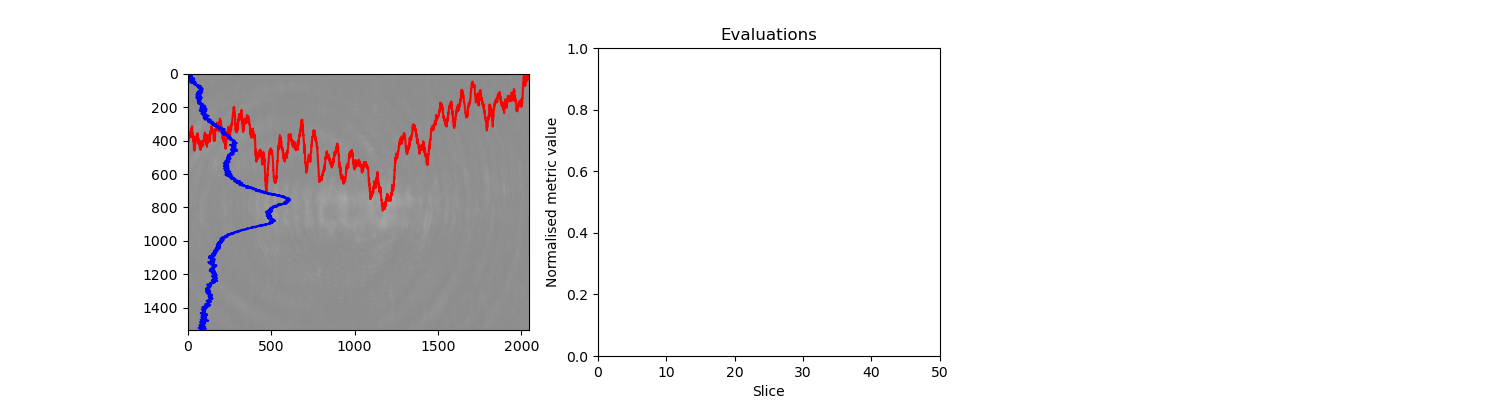

In [15]:
%matplotlib widget

#Display

targ_ax = "Y"
tmp_img = datavol[0,:,:]
lin_vmax = np.max(datavol)
sq_vmax = lin_vmax*lin_vmax

nslices = datavol.shape[0]

# Setup for live plot
fig_1 = plt.figure(figsize=(15,4))
f_1A = fig_1.add_subplot(1,3,1)
imgpixels_ref = f_1A.imshow(tmp_img,cmap='gray',vmin=0,vmax=np.max(tmp_img))
n_y_px,n_x_px = tmp_img.shape[0],tmp_img.shape[1]
scaling_frac = 0.4

scaled_x_profile = rescale(project("max","X",tmp_img),0,scaling_frac*n_x_px)
scaled_y_profile = rescale(project("max","Y",tmp_img),0,scaling_frac*n_y_px)
xplt, = f_1A.plot(scaled_x_profile,color='r')
#Little fudge to get the plot along y-x, not x-y
yplt, = f_1A.plot(scaled_y_profile,color='b')
extra_line, = f_1A.plot([0,0],color='g')
newy = yplt.get_xdata()
newx = yplt.get_ydata()
yplt.set_xdata(newx)
yplt.set_ydata(newy)

overlay_proj(fig_1,f_1A,imgpixels_ref,["max","mean"],["r","b"],tmp_img,xplt,yplt,extra_line,dummy_vals)

#Setup for processed plot
f_1B = fig_1.add_subplot(1,3,2)
f_1B.set_xlim(0,nslices-1)
f_1B.set_xlabel("Slice")
f_1B.set_ylabel("Normalised metric value")
slice_indicator = f_1B.axvline(0,0,1,linestyle=":")
proc_method="Evaluations"
f_1B.set_title(proc_method)
 
out = widgets.interactive_output(proc_img, {'slicenum': slicenum, 'gblur_x': gblur_x, 'asp_ratio': asp_ratio, 'square_it':square_it, 'scale_it':scale_it, 'bg_sub':bg_sub, 'targ_ax':targ_ax, 'proj_meth':proj_meth, 'int_pct':int_pct, 'force_stdev':force_stdev, 'savgol':savgol ,'FFT_median':FFT_median})
display(ui, out)

#Interactions
arb_max = 100
dummy_vals = None

slicenum = widgets.IntSlider(description="Slice", min=0, max=nslices-1, value=25)
gblur_x = widgets.IntSlider(description="Gblur size x", min=1, max=(2*int(datavol.shape[1]/4))+1, step=2, value=201)
asp_ratio = widgets.FloatSlider(description="Blur aspect ratio", min = 0, max = 5, step=0.05, value=2)
square_it = widgets.Checkbox(False, description='Square it')
scale_it = widgets.Checkbox(True, description='Scale display intensity')
bg_sub = widgets.Checkbox(False, description='Subtract background')
targ_ax = widgets.Dropdown(options=["X","Y"], description='Axis')
proj_meth = widgets.Dropdown(options=["max","min","mean","top 50"], description='Method')
int_pct = widgets.FloatSlider(description="Use % brightest", min=-2e-2, max=1e-1, step=1e-3, value=-2e-2, readout_format='.3e')
adaptive_smooth = widgets.Checkbox(False, description='Use adaptive smoothing')
savgol = widgets.IntSlider(description="S-G filter", min=-1, max=arb_max, value=5, stpe = 2)
FFT_median = widgets.IntSlider(description="FFT median filter", min=-1, max=arb_max, value=5, step = 2)
force_stdev = widgets.Checkbox(False, description='Force FFT stdev')
run_proc = widgets.Button(description = 'Process all slices')
clear_disp = widgets.Button(description = 'Clear graphs')

nrows = 5
ncols = 3
control_list = [slicenum, gblur_x, asp_ratio, square_it, scale_it, bg_sub, targ_ax, proj_meth, adaptive_smooth, savgol, FFT_median, int_pct, force_stdev, run_proc,clear_disp]
grid = widgets.GridspecLayout(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        if((ncols*i)+j<len(control_list)):
            grid[i, j] = control_list[(ncols*i)+j]
ui = grid

# Add click functions
@run_proc.on_click
def dclick(run_proc):
    with alive_bar(nslices,force_tty=True, title = "Processing metric") as metric_progbar:
        metric = []
        settings=targ_ax.value
        settings += " "+proj_meth.value+", "
        for slice in range(nslices):
            metric.append(proc_img(slice, gblur_x.value, asp_ratio.value, square_it.value, scale_it.value, bg_sub.value, targ_ax.value, proj_meth.value, force_stdev.value, int_pct.value, savgol.value, FFT_median.value))
            metric_progbar()
        if(square_it.value==True):
            settings += ", Sq"
        if(adaptive_smooth.value==True):
            settings+="Adap"
        else:
            settings+="Gx: "+str(gblur_x.value)+", Gasp: "+str(asp_ratio.value)
        if(savgol.value>0 and FFT_median.value>0):
            settings+=" FFT ON "
        else:
            settings+=" FFT OFF "
        if(savgol.value>0):
            settings+=", SG: "+str(savgol.value)
        if(FFT_median.value>0):
            settings+=", med: "+str(FFT_median.value)
        if(int_pct.value>=0):
            n_px = int((int_pct.value)*datavol[slice,:,:].size)
            settings="Int only, "+str(n_px)+" px"
        
        scaled_metric = (metric - np.min(metric)) / (np.max(metric) - np.min(metric))
        f_1B.plot(scaled_metric,label=settings)
        f_1B.legend(loc='center right', bbox_to_anchor=(2.2, 0.5))

@clear_disp.on_click
def clear_click(clear_disp):
    f_1B.cla()
    f_1B.set_title(proc_method)
    f_1B.set_xlabel("Slice")
    f_1B.set_ylabel("Normalised metric value")
    slice_indicator = f_1B.axvline(0,0,1,linestyle=":")

# Maybe add previously used settings dropdown?  if graph highlighted, but that isn't too trivial...